In [ ]:
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalMaxPooling2D, BatchNormalization, Dropout
from tensorflow.keras.applications import Xception
from tensorflow.keras import optimizers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Model parameters
image_size = 224
input_shape = (image_size, image_size, 3)
epochs = 50
batch_size = 32

# Define the dataset path and categories
dataset_path = '/content/drive/My Drive/new_fol_vig'
categories = ['NE', 'DME', 'DR1', 'GL']

# Initialize an empty list to store labels
labels = []

# Iterate through the directories in the dataset path
for category in categories:
    category_path = os.path.join(dataset_path, category)
    # Check if the directory exists and is indeed a directory
    if os.path.isdir(category_path):
        # List all files in the category directory
        file_names = os.listdir(category_path)
        # Iterate through each file in the directory
        for file_name in file_names:
            # Construct the full file path
            file_path = os.path.join(category_path, file_name)
            # Append the filename and category to the labels list
            labels.append((file_path, category))

# Create a DataFrame from the labels list
df = pd.DataFrame(data=labels, columns=['filename', 'category'])

# Encode the 'category' column
encoder = LabelEncoder()
df['category'] = encoder.fit_transform(df['category'])
print(df.head())
df = df.sample(frac=1).reset_index(drop=True)

# Split the DataFrame into train and validation sets
train_df, validate_df = train_test_split(df, test_size=0.2)

# Load images and labels from DataFrame
X_train = np.array([img_to_array(load_img(img_path, target_size=(image_size, image_size))) for img_path in train_df['filename']])
y_train = np.array(train_df['category'])
X_validate = np.array([img_to_array(load_img(img_path, target_size=(image_size, image_size))) for img_path in validate_df['filename']])
y_validate = np.array(validate_df['category'])

# Normalize pixel values to the range [0, 1]
X_train = X_train / 255.0
X_validate = X_validate / 255.0



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
                                            filename  category
0  /content/drive/My Drive/new_fol_vig/NE/NL_001.png         3
1  /content/drive/My Drive/new_fol_vig/NE/NL_004.png         3
2  /content/drive/My Drive/new_fol_vig/NE/NL_005.png         3
3  /content/drive/My Drive/new_fol_vig/NE/NL_006.png         3
4  /content/drive/My Drive/new_fol_vig/NE/NL_002.png         3


In [ ]:
# Define the model
pre_trained_model = Xception(input_shape=input_shape, include_top=False, weights="imagenet")
for layer in pre_trained_model.layers[:70]:
    layer.trainable = False
for layer in pre_trained_model.layers[70:]:
    layer.trainable = True
last_layer = pre_trained_model.get_layer('block14_sepconv2_act')
last_output = last_layer.output
x = GlobalMaxPooling2D()(last_output)

x = BatchNormalization()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(len(categories), activation='softmax')(x)

model = Model(pre_trained_model.input, x)

# Compile the model
model.compile(loss='sparse_categorical_crossentropy',  # Change loss function to sparse categorical cross-entropy
              optimizer=optimizers.Adam(lr=3e-4),  # Change optimizer to Adam and learning rate to 3e-4
              metrics=['accuracy'])

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_validate, y_validate), epochs=epochs, batch_size=batch_size)



Epoch 1/50
11/11 [==============================] - 37s 1s/step - loss: 1.3190 - accuracy: 0.6576 - val_loss: 0.5078 - val_accuracy: 0.7952
Epoch 2/50
11/11 [==============================] - 3s 247ms/step - loss: 1.2516 - accuracy: 0.7303 - val_loss: 3.1764 - val_accuracy: 0.6627
Epoch 3/50
11/11 [==============================] - 3s 249ms/step - loss: 0.5395 - accuracy: 0.8545 - val_loss: 2.3303 - val_accuracy: 0.6747
Epoch 4/50
11/11 [==============================] - 3s 288ms/step - loss: 0.3873 - accuracy: 0.8939 - val_loss: 2.1833 - val_accuracy: 0.6747
Epoch 5/50
11/11 [==============================] - 3s 255ms/step - loss: 0.2050 - accuracy: 0.9364 - val_loss: 1.8955 - val_accuracy: 0.7108
Epoch 6/50
11/11 [==============================] - 3s 282ms/step - loss: 0.1568 - accuracy: 0.9545 - val_loss: 3.9571 - val_accuracy: 0.6265
Epoch 7/50
11/11 [==============================] - 3s 280ms/step - loss: 0.2671 - accuracy: 0.9424 - val_loss: 0.8011 - val_accuracy: 0.8313
Epoch 8/

3/3 [==============================] - 1s 161ms/step
Classification Report:
              precision    recall  f1-score   support

          NE       1.00      1.00      1.00        19
         DME       1.00      1.00      1.00        26
         DR1       0.59      0.93      0.72        14
          GL       0.94      0.62      0.75        24

    accuracy                           0.88        83
   macro avg       0.88      0.89      0.87        83
weighted avg       0.91      0.88      0.88        83



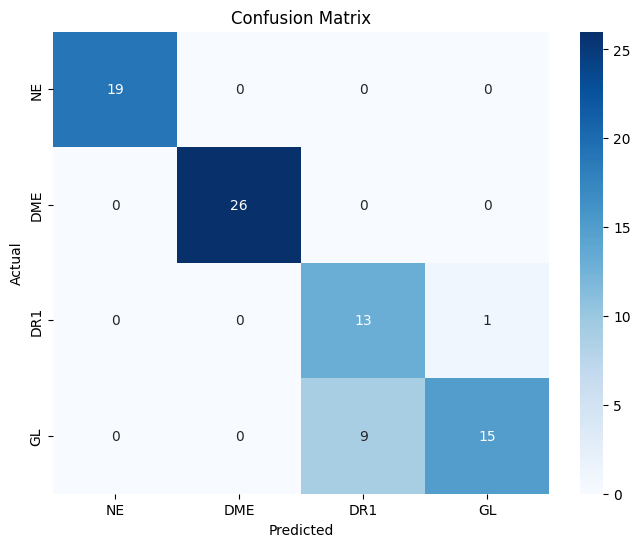

In [ ]:


# Make predictions
y_pred = np.argmax(model.predict(X_validate), axis=-1)

# Generate classification report
print("Classification Report:")
print(classification_report(y_validate, y_pred, target_names=categories))

# Generate confusion matrix
cm = confusion_matrix(y_validate, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalMaxPooling2D, BatchNormalization, Dropout
from tensorflow.keras.applications import Xception
from tensorflow.keras import optimizers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Model parameters
image_size = 224
input_shape = (image_size, image_size, 3)
epochs = 50
batch_size = 32

# Define the dataset path and categories
dataset_path = '/content/drive/My Drive/new_fol_vig'
categories = ['NE', 'DR1']

# Initialize an empty list to store labels
labels = []

for category in categories:
    category_path = os.path.join(dataset_path, category)
    if os.path.isdir(category_path):
        file_names = os.listdir(category_path)
        for file_name in file_names:
            file_path = os.path.join(category_path, file_name)
            labels.append((file_path, category))

df = pd.DataFrame(data=labels, columns=['filename', 'category'])

# Encode the 'category' column
encoder = LabelEncoder()
df['category'] = encoder.fit_transform(df['category'])
print(df.head())
df = df.sample(frac=1).reset_index(drop=True)

# Split the DataFrame into train and validation sets
train_df, validate_df = train_test_split(df, test_size=0.2)

# Load images and labels from DataFrame
X_train = np.array([img_to_array(load_img(img_path, target_size=(image_size, image_size))) for img_path in train_df['filename']])
y_train = np.array(train_df['category'])
X_validate = np.array([img_to_array(load_img(img_path, target_size=(image_size, image_size))) for img_path in validate_df['filename']])
y_validate = np.array(validate_df['category'])

# Normalize pixel values to the range [0, 1]
X_train = X_train / 255.0
X_validate = X_validate / 255.0





Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
                                            filename  category
0  /content/drive/My Drive/new_fol_vig/NE/NL_001.png         1
1  /content/drive/My Drive/new_fol_vig/NE/NL_004.png         1
2  /content/drive/My Drive/new_fol_vig/NE/NL_005.png         1
3  /content/drive/My Drive/new_fol_vig/NE/NL_006.png         1
4  /content/drive/My Drive/new_fol_vig/NE/NL_002.png         1


In [ ]:
# Define the model
pre_trained_model = Xception(input_shape=input_shape, include_top=False, weights="imagenet")
for layer in pre_trained_model.layers[:70]:
    layer.trainable = False
for layer in pre_trained_model.layers[70:]:
    layer.trainable = True
last_layer = pre_trained_model.get_layer('block14_sepconv2_act')
last_output = last_layer.output
x = GlobalMaxPooling2D()(last_output)

x = BatchNormalization()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(len(categories), activation='softmax')(x)

model = Model(pre_trained_model.input, x)

# Compile the model
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=optimizers.Adam(lr=3e-4),
              metrics=['accuracy'])

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_validate, y_validate), epochs=epochs, batch_size=batch_size)

Epoch 1/50
6/6 [==============================] - 22s 1s/step - loss: 0.2979 - accuracy: 0.8793 - val_loss: 10.6648 - val_accuracy: 0.4545
Epoch 2/50
6/6 [==============================] - 2s 280ms/step - loss: 2.7683e-04 - accuracy: 1.0000 - val_loss: 18.0419 - val_accuracy: 0.4545
Epoch 3/50
6/6 [==============================] - 2s 254ms/step - loss: 8.9811e-07 - accuracy: 1.0000 - val_loss: 19.2139 - val_accuracy: 0.4545
Epoch 4/50
6/6 [==============================] - 2s 254ms/step - loss: 0.1774 - accuracy: 0.9943 - val_loss: 6.6525 - val_accuracy: 0.4545
Epoch 5/50
6/6 [==============================] - 2s 281ms/step - loss: 0.1428 - accuracy: 0.9943 - val_loss: 0.0221 - val_accuracy: 0.9773
Epoch 6/50
6/6 [==============================] - 2s 258ms/step - loss: 0.0184 - accuracy: 0.9943 - val_loss: 1.6053e-05 - val_accuracy: 1.0000
Epoch 7/50
6/6 [==============================] - 2s 261ms/step - loss: 1.3880e-05 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000

2/2 [==============================] - 1s 173ms/step
Classification Report:
              precision    recall  f1-score   support

          NE       1.00      1.00      1.00        24
         DR1       1.00      1.00      1.00        20

    accuracy                           1.00        44
   macro avg       1.00      1.00      1.00        44
weighted avg       1.00      1.00      1.00        44



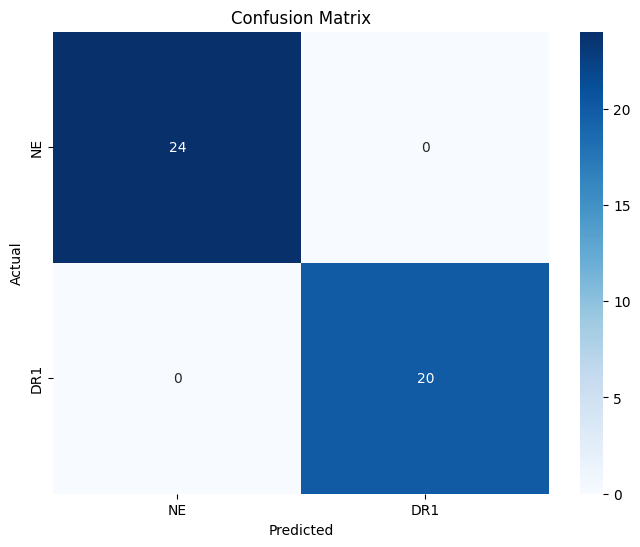

In [ ]:


# Make predictions
y_pred = np.argmax(model.predict(X_validate), axis=-1)

# Generate classification report
print("Classification Report:")
print(classification_report(y_validate, y_pred, target_names=categories))

# Generate confusion matrix
cm = confusion_matrix(y_validate, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [ ]:

# Mount Google Drive
drive.mount('/content/drive')

# Model parameters
image_size = 224
input_shape = (image_size, image_size, 3)
epochs = 50
batch_size = 32

# Define the dataset path and categories
dataset_path = '/content/drive/My Drive/new_fol_vig'
categories = ['NE', 'DME' ]

# Initialize an empty list to store labels
labels = []

# Iterate through the directories in the dataset path
for category in categories:
    category_path = os.path.join(dataset_path, category)
    # Check if the directory exists and is indeed a directory
    if os.path.isdir(category_path):
        # List all files in the category directory
        file_names = os.listdir(category_path)
        # Iterate through each file in the directory
        for file_name in file_names:
            # Construct the full file path
            file_path = os.path.join(category_path, file_name)
            # Append the filename and category to the labels list
            labels.append((file_path, category))

# Create a DataFrame from the labels list
df = pd.DataFrame(data=labels, columns=['filename', 'category'])

# Encode the 'category' column
encoder = LabelEncoder()
df['category'] = encoder.fit_transform(df['category'])
print(df.head())
df = df.sample(frac=1).reset_index(drop=True)

# Split the DataFrame into train and validation sets
train_df, validate_df = train_test_split(df, test_size=0.2)

# Load images and labels from DataFrame
X_train = np.array([img_to_array(load_img(img_path, target_size=(image_size, image_size))) for img_path in train_df['filename']])
y_train = np.array(train_df['category'])
X_validate = np.array([img_to_array(load_img(img_path, target_size=(image_size, image_size))) for img_path in validate_df['filename']])
y_validate = np.array(validate_df['category'])

# Normalize pixel values to the range [0, 1]
X_train = X_train / 255.0
X_validate = X_validate / 255.0

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
                                            filename  category
0  /content/drive/My Drive/new_fol_vig/NE/NL_001.png         1
1  /content/drive/My Drive/new_fol_vig/NE/NL_004.png         1
2  /content/drive/My Drive/new_fol_vig/NE/NL_005.png         1
3  /content/drive/My Drive/new_fol_vig/NE/NL_006.png         1
4  /content/drive/My Drive/new_fol_vig/NE/NL_002.png         1


In [ ]:
# Define the model
pre_trained_model = Xception(input_shape=input_shape, include_top=False, weights="imagenet")
for layer in pre_trained_model.layers[:70]:
    layer.trainable = False
for layer in pre_trained_model.layers[70:]:
    layer.trainable = True
last_layer = pre_trained_model.get_layer('block14_sepconv2_act')
last_output = last_layer.output
x = GlobalMaxPooling2D()(last_output)

x = BatchNormalization()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(len(categories), activation='softmax')(x)

model = Model(pre_trained_model.input, x)

# Compile the model
model.compile(loss='sparse_categorical_crossentropy',  # Change loss function to sparse categorical cross-entropy
              optimizer=optimizers.Adam(lr=3e-4),  # Change optimizer to Adam and learning rate to 3e-4
              metrics=['accuracy'])

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_validate, y_validate), epochs=epochs, batch_size=batch_size)

Epoch 1/50
5/5 [==============================] - 23s 2s/step - loss: 0.9677 - accuracy: 0.7248 - val_loss: 1.9738 - val_accuracy: 0.7105
Epoch 2/50
5/5 [==============================] - 1s 301ms/step - loss: 0.4043 - accuracy: 0.9128 - val_loss: 0.6300 - val_accuracy: 0.8947
Epoch 3/50
5/5 [==============================] - 1s 266ms/step - loss: 0.1762 - accuracy: 0.9664 - val_loss: 0.5952 - val_accuracy: 0.8947
Epoch 4/50
5/5 [==============================] - 1s 265ms/step - loss: 0.3851 - accuracy: 0.9463 - val_loss: 0.0758 - val_accuracy: 0.9737
Epoch 5/50
5/5 [==============================] - 1s 301ms/step - loss: 0.0813 - accuracy: 0.9866 - val_loss: 0.2951 - val_accuracy: 0.9737
Epoch 6/50
5/5 [==============================] - 1s 264ms/step - loss: 0.1048 - accuracy: 0.9933 - val_loss: 0.2617 - val_accuracy: 0.9737
Epoch 7/50
5/5 [==============================] - 1s 265ms/step - loss: 0.0823 - accuracy: 0.9732 - val_loss: 0.0626 - val_accuracy: 0.9737
Epoch 8/50
5/5 [======

2/2 [==============================] - 1s 167ms/step
Classification Report:
              precision    recall  f1-score   support

          NE       1.00      0.91      0.95        22
         DME       0.89      1.00      0.94        16

    accuracy                           0.95        38
   macro avg       0.94      0.95      0.95        38
weighted avg       0.95      0.95      0.95        38



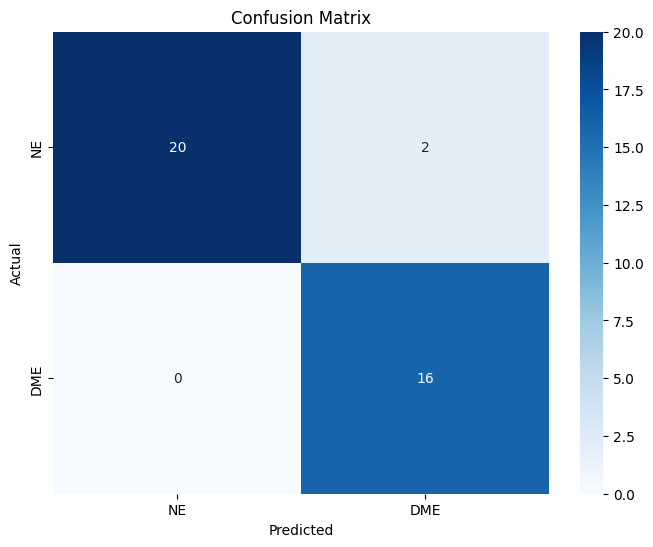

In [ ]:

# Make predictions
y_pred = np.argmax(model.predict(X_validate), axis=-1)

# Generate classification report
print("Classification Report:")
print(classification_report(y_validate, y_pred, target_names=categories))

# Generate confusion matrix
cm = confusion_matrix(y_validate, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [ ]:

# Mount Google Drive
drive.mount('/content/drive')

# Model parameters
image_size = 224
input_shape = (image_size, image_size, 3)
epochs = 50
batch_size = 32

# Define the dataset path and categories
dataset_path = '/content/drive/My Drive/new_fol_vig'
categories = ['NE',  'GL']

# Initialize an empty list to store labels
labels = []

# Iterate through the directories in the dataset path
for category in categories:
    category_path = os.path.join(dataset_path, category)
    # Check if the directory exists and is indeed a directory
    if os.path.isdir(category_path):
        # List all files in the category directory
        file_names = os.listdir(category_path)
        # Iterate through each file in the directory
        for file_name in file_names:
            # Construct the full file path
            file_path = os.path.join(category_path, file_name)
            # Append the filename and category to the labels list
            labels.append((file_path, category))

# Create a DataFrame from the labels list
df = pd.DataFrame(data=labels, columns=['filename', 'category'])

# Encode the 'category' column
encoder = LabelEncoder()
df['category'] = encoder.fit_transform(df['category'])
print(df.head())
df = df.sample(frac=1).reset_index(drop=True)

# Split the DataFrame into train and validation sets
train_df, validate_df = train_test_split(df, test_size=0.2)

# Load images and labels from DataFrame
X_train = np.array([img_to_array(load_img(img_path, target_size=(image_size, image_size))) for img_path in train_df['filename']])
y_train = np.array(train_df['category'])
X_validate = np.array([img_to_array(load_img(img_path, target_size=(image_size, image_size))) for img_path in validate_df['filename']])
y_validate = np.array(validate_df['category'])

# Normalize pixel values to the range [0, 1]
X_train = X_train / 255.0
X_validate = X_validate / 255.0

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
                                            filename  category
0  /content/drive/My Drive/new_fol_vig/NE/NL_001.png         1
1  /content/drive/My Drive/new_fol_vig/NE/NL_004.png         1
2  /content/drive/My Drive/new_fol_vig/NE/NL_005.png         1
3  /content/drive/My Drive/new_fol_vig/NE/NL_006.png         1
4  /content/drive/My Drive/new_fol_vig/NE/NL_002.png         1


In [ ]:
# Define the model
pre_trained_model = Xception(input_shape=input_shape, include_top=False, weights="imagenet")
for layer in pre_trained_model.layers[:70]:
    layer.trainable = False
for layer in pre_trained_model.layers[70:]:
    layer.trainable = True
last_layer = pre_trained_model.get_layer('block14_sepconv2_act')
last_output = last_layer.output
x = GlobalMaxPooling2D()(last_output)

x = BatchNormalization()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(len(categories), activation='softmax')(x)

model = Model(pre_trained_model.input, x)

# Compile the model
model.compile(loss='sparse_categorical_crossentropy',  # Change loss function to sparse categorical cross-entropy
              optimizer=optimizers.Adam(lr=3e-4),  # Change optimizer to Adam and learning rate to 3e-4
              metrics=['accuracy'])

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_validate, y_validate), epochs=epochs, batch_size=batch_size)

Epoch 1/50
5/5 [==============================] - 22s 2s/step - loss: 1.5400 - accuracy: 0.5548 - val_loss: 5.2355 - val_accuracy: 0.4103
Epoch 2/50
5/5 [==============================] - 1s 276ms/step - loss: 1.0619 - accuracy: 0.7935 - val_loss: 2.2562 - val_accuracy: 0.5385
Epoch 3/50
5/5 [==============================] - 1s 277ms/step - loss: 0.8249 - accuracy: 0.8000 - val_loss: 2.9597 - val_accuracy: 0.4103
Epoch 4/50
5/5 [==============================] - 1s 314ms/step - loss: 0.8819 - accuracy: 0.8387 - val_loss: 5.9769 - val_accuracy: 0.5128
Epoch 5/50
5/5 [==============================] - 1s 278ms/step - loss: 0.8626 - accuracy: 0.8323 - val_loss: 9.3499 - val_accuracy: 0.4615
Epoch 6/50
5/5 [==============================] - 1s 315ms/step - loss: 0.4800 - accuracy: 0.9484 - val_loss: 6.2725 - val_accuracy: 0.6154
Epoch 7/50
5/5 [==============================] - 1s 287ms/step - loss: 0.2572 - accuracy: 0.9226 - val_loss: 8.4047 - val_accuracy: 0.5897
Epoch 8/50
5/5 [======

2/2 [==============================] - 1s 171ms/step
Classification Report:
              precision    recall  f1-score   support

          NE       0.55      1.00      0.71        16
          GL       1.00      0.43      0.61        23

    accuracy                           0.67        39
   macro avg       0.78      0.72      0.66        39
weighted avg       0.82      0.67      0.65        39



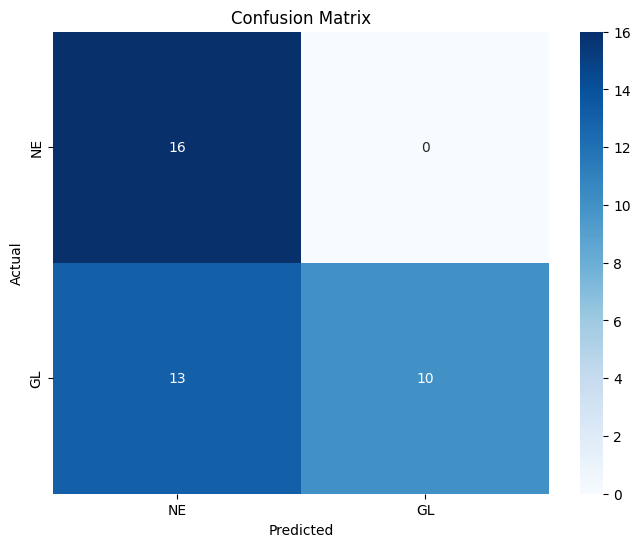

In [ ]:

# Make predictions
y_pred = np.argmax(model.predict(X_validate), axis=-1)

# Generate classification report
print("Classification Report:")
print(classification_report(y_validate, y_pred, target_names=categories))

# Generate confusion matrix
cm = confusion_matrix(y_validate, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
